# Predcition of Hospital Admission Related to Urinary Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to urinary tract infection (UTI). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import scipy.stats as st
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'uti_date_'+str(i), 'uti_ab_date_'+str(i), 'uti_ab_type_'+str(i),
                   'incdt_uti_date_'+str(i), 'admitted_uti_date_'+str(i), 'sgss_gp_cov_uti_date_'+str(i)]]
    
    #drop rows with no uti reord
    datum = datum[datum['uti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with uti_i
    datum = datum[datum['sgss_gp_cov_uti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'uti_date_'+str(i): 'uti_date', 'uti_ab_date_'+str(i): 'uti_ab_date', 
                           'uti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_uti_date_'+str(i): 'incdt_uti_date', 'incdt_uti_type_'+str(i): 'incdt_uti_type',
                           'admitted_uti_date_'+str(i): 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_'+str(i): 'sgss_gp_cov_uti_date'},
                inplace=True)
    
    return datum

In [5]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [6]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_uti_admitted',
            event_col='event_uti_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_uti_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a columns of risk factors, prescribed antibiotics, and hosp event 
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary', 'event_'+infection+'_admitted']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count', 'event_'+infection+'_admitted_mean', 'event_'+infection+'_admitted_sum', 'event_'+infection+'_admitted_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)

    #save prob_pred for analysis in r
    prob_pred.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis.csv', index=False)

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    #save prob_pred_enc_lr_rf for analysis in r
    prob_pred_enc_lr_rf.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis_binned.csv', index=False)

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier()#n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #caculate ORs and intervals of LR model, save and print them 
    # lr_coef = pd.DataFrame({"or": lr.coef_})#, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef_exp = np.exp(lr_coef)
    # lr_coef_exp.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    # lr_coef = lr.coef_
    # print('LR ORs:\n %s'%(lr_coef))
    # lr_coef = pd.DataFrame(data=np.exp(lr.coef_), index=data_enc_dev_x.columns, columns=['lr_coef'])
    # lr_coef = lr_coef.sort_values('lr_coef', ascending=False)
    # lr_coef = pd.DataFrame(data=lr.coef_.T, index=data_enc_dev_x.columns, columns=['lr_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # # lr_coef['lr_coef_lower_bound'] = st.norm.ppf(lr_coef['lr_coef'])
    
    # alpha = 0.05
    # #the coefficients of the regression model
    # coefs = np.r_[lr.coef_.T.tolist()]#[lr.intercept_], lr.coef_.T.tolist()
    # #build an auxiliary dataframe with the constant term in it
    # X_aux = data_enc_dev_x.copy()
    # # X_aux.insert(0, 'const', 1)
    # #degrees of freedom
    # dof = -np.diff(X_aux.shape)[0]
    # #Student's t-distribution table lookup
    # t_val = stats.t.isf(alpha/2, dof)
    # #MSE of the residuals
    # mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
    # #inverse of the variance of the parameters
    # var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    # #distance between lower and upper bound of CI
    # gap = t_val * np.sqrt(mse * var_params)
    # lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
    # lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
    # # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
    # lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # rf_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR model with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [9]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    # #print summary of LR model
    # lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef = np.exp(lr_coef)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    # print('LR coefficients:\n %s'%(lr_coef))
    
#     alpha = 0.05
#     #the coefficients of the regression model
#     coefs = np.r_[lr.coef_.T.tolist()] #[lr.intercept_], lr.coef_.T.tolist()
#     #build an auxiliary dataframe with the constant term in it
#     X_aux = data_enc_dev_x.copy()
#    #  X_aux.insert(0, 'const', 1)
#     #degrees of freedom
#     dof = -np.diff(X_aux.shape)[0]
#     #Student's t-distribution table lookup
#     t_val = stats.t.isf(alpha/2, dof)
#     #MSE of the residuals
#     mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
#     #inverse of the variance of the parameters
#     var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
#     #distance between lower and upper bound of CI
#     gap = t_val * np.sqrt(mse * var_params)
#     lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
#     lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
#     # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
#     lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [10]:
#bootstrap and create lr models
def lr_bootstrap(data):
    sample = data.sample(data.shape[0], replace=True)
    X_tr = sample[[c for c in sample.columns if c != 'ab_binary']]
    y_tr = sample.ab_binary
    lr = LogisticRegression().fit(X_tr, y_tr)
    params = list(lr.coef_[0]) 

    return params

In [11]:
#calculate mean and standard error of lr models with bootstraped data to calculate mean coeffients and intervals of coefficients and odds ratios and their intervals
def get_lr_betas_intervals(data):
    #get column names of inputs
    data_x_columns = data.drop('ab_binary', axis=1).columns
    #create lr models with bootstraped samples for 100 times
    params_samples = pd.DataFrame([lr_bootstrap(data) for _ in range(100)])
    #calculate mean and standard error for coefficients of lrs with samples
    coefs_mean = params_samples.mean()
    coefs_se = params_samples.std()
    z_val = stats.norm.ppf(0.975)
    coefs_se_z_val = coefs_se * z_val
    #create a table of coefficients and their intervals for covariates 
    lr_summary = pd.DataFrame({'covariate': data_x_columns.tolist(), 'coef': coefs_mean, 'coef_lower_95%': coefs_mean - coefs_se_z_val, 'coef_upper_95%': coefs_mean + coefs_se_z_val})
    #clculate odds ratios and their intervals for covariates
    lr_summary[['or', 'or_lower_95%', 'or_upper_95%']] = np.exp(lr_summary[['coef', 'coef_lower_95%', 'coef_upper_95%']])

    return lr_summary

In [12]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val):#, rf_pred_dev, rf_pred_val):
    # ##calibration for RF
    # rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    # #
    # rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    # #plot calibration plot for RF model with development and validation data
    # fig, ax1 = plt.subplots(figsize=(7, 7))
    # plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    # plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    # plt.xlabel('Mean predicted probabilities', fontsize=14)
    # plt.ylabel('Proportion of observed values', fontsize=14)
    # plt.xticks(fontsize=12)
    # plt.yticks(fontsize=12, rotation=0)
    # plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    # plt.title("Calibration plot of RF model", fontsize=14)
    # legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    # legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    # plt.legend(handles=[legend_dev, legend_val])
    # plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    # plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [13]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_uti.csv.gz')

In [14]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [15]:
#process 20 utis and concatenate them 
data_uti_1 = proc_infec_data(data,1)
data_uti_2 = proc_infec_data(data,2)
data_uti_3 = proc_infec_data(data,3)
data_uti_4 = proc_infec_data(data,4)
data_uti_5 = proc_infec_data(data,5)
data_uti_6 = proc_infec_data(data,6)
data_uti_7 = proc_infec_data(data,7)
data_uti_8 = proc_infec_data(data,8)
data_uti_9 = proc_infec_data(data,9)
data_uti_10 = proc_infec_data(data,10)
data_uti_11 = proc_infec_data(data,11)
data_uti_12 = proc_infec_data(data,12)
data_uti_13 = proc_infec_data(data,13)
data_uti_14 = proc_infec_data(data,14)
data_uti_15 = proc_infec_data(data,15)
data_uti_16 = proc_infec_data(data,16)
data_uti_17 = proc_infec_data(data,17)
data_uti_18 = proc_infec_data(data,18)
data_uti_19 = proc_infec_data(data,19)
data_uti_20 = proc_infec_data(data,20)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4, data_uti_5, data_uti_6, data_uti_7, data_uti_8, data_uti_9, data_uti_10, data_uti_11, data_uti_12, data_uti_13, data_uti_14, data_uti_15, data_uti_16, data_uti_17, data_uti_18, data_uti_19, data_uti_20])
data_uti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [16]:
##add variable season
#convert data types
data_uti['uti_date'] = data_uti['uti_date'].astype('datetime64[ns]')
data_uti['admitted_uti_date'] = data_uti['admitted_uti_date'].astype('datetime64[ns]')
data_uti.died_date = data_uti.died_date.astype('datetime64[ns]')
data_uti.deregistered_date = data_uti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_uti['date'] = data_uti['uti_date'] 
data_uti['date'] = data_uti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_uti with today's date in year and month
data_uti = data_uti[data_uti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_uti = data_uti[data_uti['date'] != last_1_month_date_y_m]
data_uti = data_uti[data_uti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of uti records
data_uti['season'] = np.nan
data_uti['date_month'] = pd.DatetimeIndex(data_uti['date']).month

conditions = [
    (data_uti['date_month'] >= 3) & (data_uti['date_month'] <= 5),
    (data_uti['date_month'] >= 6) & (data_uti['date_month'] <= 8),
    (data_uti['date_month'] >= 9) & (data_uti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_uti['season'] = np.select(conditions, choices, default='winter')

In [17]:
#add variable time period
data_uti.loc[(data_uti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_uti.loc[((data_uti['date'] >= '2020-05') & (data_uti['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_uti.loc[(data_uti['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

In [18]:
data_uti['date'].max()

'2023-05'

#### event and duration

In [19]:
#scenario 1
#not hosped (nothing happened)
data_uti.loc[data_uti['admitted_uti_date'].isnull(), 'event_uti_admitted'] = 0

In [20]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days
data_uti.loc[((data_uti['delta_uti_admitted'] >= 0) & (data_uti['delta_uti_admitted'] <= 30)), 'event_uti_admitted'] = 1

#scenario 2
#drop whoever was admitted before uti consultation, i.e. negative value for delta_uti_admitted
data_uti = data_uti[~(data_uti['delta_uti_admitted'] < 0)]

In [21]:
#scenario 3
#censor died patients
data_uti['delta_admitted_died'] = (data_uti['died_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_died'] >= 0) & (data_uti['delta_admitted_died'] <= 30)), 'event_uti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_uti['delta_admitted_deregistered'] = (data_uti['deregistered_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_deregistered'] > 0) & (data_uti['delta_admitted_deregistered'] <= 30)), 'event_uti_admitted'] = 0

#agg scenario 3s
data_uti['delta_admitted_died_deregistered'] = data_uti['delta_admitted_deregistered'].combine_first(data_uti['delta_admitted_died'])
data_uti.loc[data_uti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [22]:
#scenario 1
#any other patients (nothing happened)
data_uti['event_uti_admitted'] = data_uti['event_uti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_uti['duration_uti_admitted'] = data_uti['delta_uti_admitted'].combine_first(data_uti['delta_admitted_died_deregistered'])
data_uti['duration_uti_admitted'] = data_uti['duration_uti_admitted'].replace(np.NaN, 30)
data_uti.loc[(data_uti['duration_uti_admitted'] > 30), 'duration_uti_admitted'] = 30

#give value 1 to event_uti_admitted if duration_uti_admitted is greater or equal to 0 and less than 30
data_uti.loc[((data_uti['duration_uti_admitted'] >= 0) & (data_uti['duration_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

#drop any rows with value 0 in duration column
data_uti = data_uti[~(data_uti['duration_uti_admitted'] == 0)]

In [23]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_uti.loc[((data_uti['delta_uti_admitted'] > 0) & (data_uti['delta_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [24]:
#drop anybody with age less than 18 or 0!
data_uti = data_uti[~(data_uti['age'] < 18)] 
data_uti['age'][data_uti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_uti = data_uti[data_uti['age_cat'] != '0-4']
data_uti = data_uti[data_uti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_uti['bmi'][data_uti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_uti['bmi'] = data_uti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_uti['antibacterial_brit'][data_uti['antibacterial_brit'] < 0] = np.nan

In [25]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"smoking": dict_smoking})

In [26]:
#drop rows with missing region
if ('region' in data_uti.columns) and (data_uti['region'].isnull().sum() > 0):
   data_uti = data_uti[data_uti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_uti.columns) and (data_uti['antibacterial_brit'].isnull().sum() > 0):
    data_uti['antibacterial_brit'] = data_uti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_uti.columns) and (data_uti['ethnicity'].isnull().sum() > 0):
    data_uti['ethnicity'] = data_uti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_uti.columns) and (data_uti['smoking'].isnull().sum() > 0):
    data_uti['smoking'] = data_uti['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_uti.columns) and (data_uti['imd'].isnull().sum() > 0):
    data_uti['imd'] = data_uti['imd'].fillna(0)

In [27]:
#missing values of bmi assign 5 and 0; categorise bmi
data_uti['bmi_cat'] = 5

for idx, x in enumerate(data_uti['bmi_cat']):
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 30:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 25) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 30):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 18.5) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 25):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 18.5:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_uti.columns) and (data_uti['bmi_cat'].isnull().sum() > 0):
    data_uti['bmi_cat'] = data_uti['bmi_cat'].fillna(0)

In [28]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_uti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_uti['ab_type_cat'] = np.where(data_uti['ab_type'].isin(ab_series[mask].index),'other',data_uti['ab_type'])
#assign no to non ab users
data_uti.loc[data_uti['uti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_uti['ab_type_cat'] = data_uti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [29]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"ethnicity": dict_ethnicity})
data_uti = data_uti.replace({"smoking": dict_smoking})
data_uti = data_uti.replace({"imd": dict_imd})
data_uti = data_uti.replace({"bmi_cat": dict_bmi})
data_uti = data_uti.replace({"flu_vaccine": dict_flu})
data_uti = data_uti.replace({"region": dict_region})
data_uti = data_uti.replace({"age_cat": dict_age})
data_uti = data_uti.replace({"ab_type_cat": dict_ab_type})

In [30]:
data_uti.ethnicity.value_counts('NA')

white      0.600145
unknown    0.251669
asian      0.074118
other      0.074069
Name: ethnicity, dtype: float64

In [31]:
data_uti.smoking.value_counts('NA')

unknown         0.416296
smoker          0.389583
never_smoked    0.128137
ex_smoker       0.065985
Name: smoking_status, dtype: float64

In [32]:
data_uti.bmi_cat.value_counts('NA')

obese             0.516201
unknown           0.257602
overweight        0.111316
healthy_weight    0.083106
underweight       0.031776
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [33]:
#categorise CCI
data_uti['CCI_cat'] = pd.cut(data_uti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_uti['antibacterial_brit'].clip(0, data_uti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

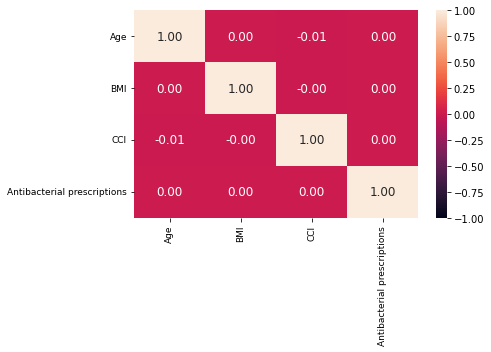

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_uti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/corr_uti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [35]:
data_uti = data_uti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'uti_ab_date', 'ab_type_cat', 'incdt_uti_date', 'date', 'period',
                                   'event_uti_admitted', 'duration_uti_admitted'
                                    ]]

In [36]:
#switch variable uti_ab_date into a binary variable
data_uti[['ab_binary']] = data_uti[['uti_ab_date']].where(data_uti[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_uti_incdt = data_uti[data_uti['incdt_uti_date'] == 0]
data_uti_prevl = data_uti[data_uti['incdt_uti_date'] == 1]

#no antibiotics and incident hospital admission
data_uti_no_abs_incdt = data_uti_incdt[data_uti_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_uti_abs_incdt = data_uti_incdt[data_uti_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_uti_no_abs_prevl = data_uti_prevl[data_uti_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_uti_abs_prevl = data_uti_prevl[data_uti_prevl['ab_binary'] == 1]

In [37]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_uti_incdt_prepandemic = data_uti_incdt[data_uti_incdt['period'] == 'prepandemic']
data_uti_incdt_during_pandemic = data_uti_incdt[(data_uti_incdt['period'] == 'during_pandemic')]
data_uti_incdt_post_2nd_lockdown = data_uti_incdt[data_uti_incdt['period'] == 'post_2nd_lockdown']
data_uti_prevl_prepandemic = data_uti_prevl[data_uti_prevl['period'] == 'prepandemic']
data_uti_prevl_during_pandemic = data_uti_prevl[(data_uti_prevl['period'] == 'during_pandemic')]
data_uti_prevl_post_2nd_lockdown = data_uti_prevl[data_uti_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_uti_no_abs_incdt_prepandemic = data_uti_incdt_prepandemic[data_uti_incdt_prepandemic['ab_binary'] == 0]
data_uti_no_abs_incdt_during_pandemic = data_uti_incdt_during_pandemic[data_uti_incdt_during_pandemic['ab_binary'] == 0]
data_uti_no_abs_incdt_post_2nd_lockdown = data_uti_incdt_post_2nd_lockdown[data_uti_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_uti_no_abs_prevl_prepandemic = data_uti_prevl_prepandemic[data_uti_prevl_prepandemic['ab_binary'] == 0]
data_uti_no_abs_prevl_during_pandemic = data_uti_prevl_during_pandemic[data_uti_prevl_during_pandemic['ab_binary'] == 0]
data_uti_no_abs_prevl_post_2nd_lockdown = data_uti_prevl_post_2nd_lockdown[data_uti_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_uti
# save data
data_uti.to_csv('../output/hospitalisation_prediction_uti/data_uti.csv')

Stored 'data_uti' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [39]:
#make summary tables
make_summary_table('uti', 'no_abs_incdt', data_uti_no_abs_incdt)
make_summary_table('uti', 'abs_incdt', data_uti_abs_incdt)
make_summary_table('uti', 'no_abs_prevl', data_uti_no_abs_prevl)
make_summary_table('uti', 'abs_prevl', data_uti_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 111599 total observations, 110873 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 111599
number of events observed = 726
   partial log-likelihood = -8420.15
         time fit was run = 2023-08-07 22:06:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.11            -0.37             0.06                 0.69                 1.07
CCI_cat[T.medium]               -0.01       0.99       0.12            -0.25             0.22                 0.78                 1.25
CCI_cat[T.high]                  0.06       1.06       0.14            -0.21             0.33                 0.81                 1.40
CCI_cat[T.very_high]             0.03       1.03       0.12            -0.21             0.28                 0.81                 1.32
age_cat[T.25_34]                -0.10       0.90       0.14            -0.37             0.17                 0.69                 1.19
age_cat[T.35_44]                -0.08       0.92       0.14            -0.36             0.19                 0.70                 1.21
age_cat[T.45_54]                 0.02       1.02       0.14            -0.24             0.29                 0.78                 1.34
age_cat[T.55_64]                -0.17       0.84       0.14            -0.45             0.11                 0.64                 1.12
age_cat[T.65_74]                -0.02       0.98       0.14            -0.29             0.25                 0.75                 1.28
age_cat[T.75_more]               0.04       1.04       0.14            -0.22             0.31                 0.80                 1.36
antibacterial_brit              -0.05       0.95       0.03            -0.11            -0.00                 0.90                 1.00
bmi_cat[T.obese]                 0.10       1.10       0.14            -0.18             0.37                 0.83                 1.45
bmi_cat[T.overweight]           -0.06       0.94       0.18            -0.41             0.29                 0.66                 1.33
bmi_cat[T.underweight]          -0.10       0.91       0.26            -0.61             0.41                 0.55                 1.51
bmi_cat[T.unknown]               0.04       1.05       0.15            -0.25             0.34                 0.78                 1.41
ethnicity[T.other]              -0.28       0.76       0.20            -0.66             0.11                 0.52                 1.12
ethnicity[T.unknown]            -0.10       0.91       0.15            -0.39             0.20                 0.68                 1.22
ethnicity[T.white]              -0.10       0.90       0.14            -0.37             0.17                 0.69                 1.18
flu_vaccine[T.yes]              -0.04       0.96       0.13            -0.29             0.20                 0.75                 1.22
imd[T.medium]                   -0.00       1.00       0.12            -0.23             0.23                 0.79                 1.26
imd[T.unaffluent]               -0.04       0.96       0.12            -0.27             0.19                 0.76                 1.21
imd[T.unknown]                   0.04       1.04       0.18            -0.32             0.40                 0.73                 1.49
imd[T.very_affluent]            -0.09       0.92       0.12            -0.32             0.15                 0.72                 1.16
imd[T.very_unaffluent]          -0.13       0.87       0.12            -0.37             0.10                 0.69                 1.11
region[T.east_midlands]         -0.16       0.85       0.17        

13055


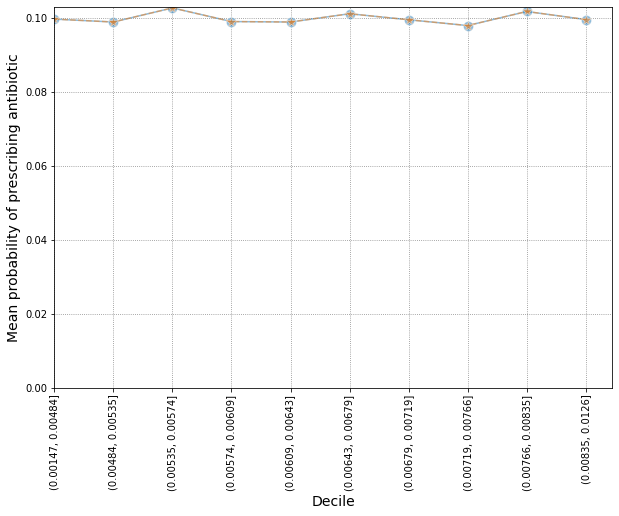


AUROC of LR for deciles with development and validation data: 0.50405 and 0.49746
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00484, 0.00535] -0.018561       -0.111901        0.074778   
1  bins_(0.00535, 0.00574] -0.007549       -0.097074        0.081975   
2  bins_(0.00574, 0.00609] -0.019213       -0.106839        0.068413   
3  bins_(0.00609, 0.00643] -0.010181       -0.097646        0.077283   
4  bins_(0.00643, 0.00679] -0.023796       -0.109640        0.062049   
5  bins_(0.00679, 0.00719] -0.018534       -0.104203        0.067136   
6  bins_(0.00719, 0.00766] -0.047261       -0.131057        0.036534   
7  bins_(0.00766, 0.00835]  0.006304       -0.076459        0.089068   
8   bins_(0.00835, 0.0126] -0.039014       -0.120068        0.042040   

         or  or_lower_95%  or_upper_95%  
0  0.981610      0.894133      1.077645  
1  0.992479      0.907489      1.085429  
2  0.980970      0.898670      1.070807  
3  0.989870    

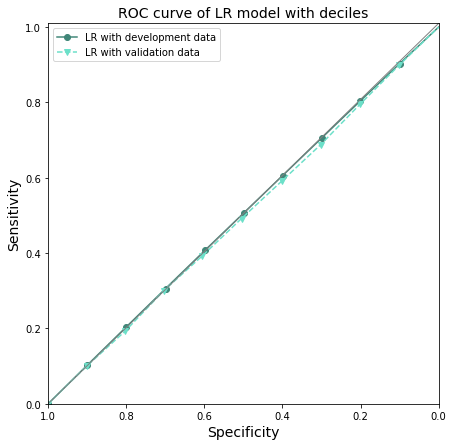

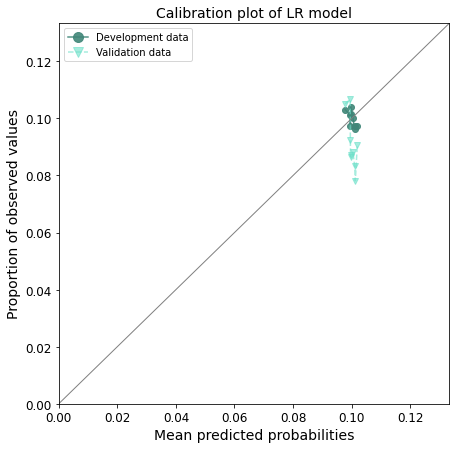


AUROC of LR for risk factors with development and validation data: 0.51725 and 0.50195
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34 -0.069378       -0.131990       -0.006766   
1                 age_cat_35_44 -0.054474       -0.120467        0.011519   
2                 age_cat_45_54 -0.094547       -0.170025       -0.019069   
3                 age_cat_55_64 -0.078102       -0.150685       -0.005518   
4                 age_cat_65_74 -0.014138       -0.084945        0.056668   
5               age_cat_75_more -0.080222       -0.147788       -0.012657   
6                      sex_male -0.000221       -0.034713        0.034271   
7                  CCI_cat_high -0.000435       -0.075547        0.074677   
8                   CCI_cat_low  0.058669        0.007532        0.109806   
9                CCI_cat_medium  0.064080        0.005892        0.122267   
10            CCI_cat_very_high  0.086804        0.0

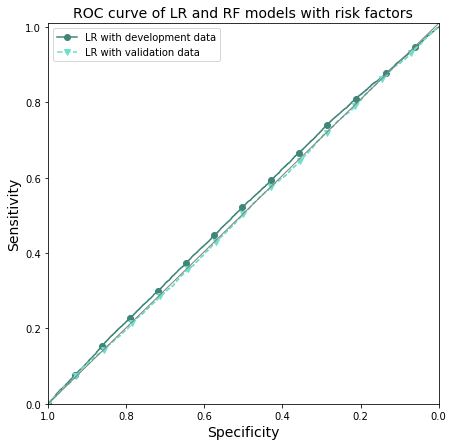

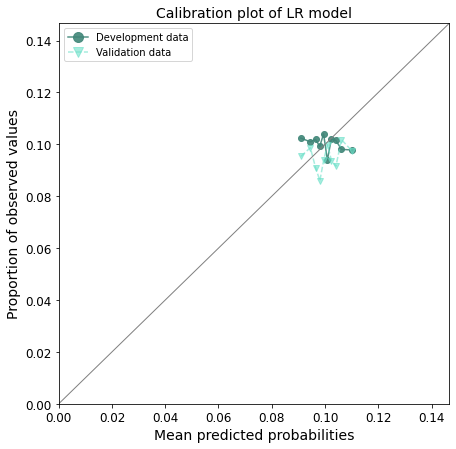

In [40]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_uti_no_abs_incdt, prob_pred_uti_no_abs_incdt_bin = cox_build('uti', 'incdt', data_uti_incdt, data_uti_no_abs_incdt)
except:
    print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_deciles('uti', 'incdt_deciles', prob_pred_uti_no_abs_incdt)
#calibration plots of rf and lr with deciles
calibration_rf_lr('uti', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('uti', 'incdt', prob_pred_enc_lr_rf_incdt)

# try:
#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_riskfactors('uti', 'incdt_riskfactors', prob_pred_uti_no_abs_incdt)
#calibration plots of rf and lr with risk factors
calibration_rf_lr('uti', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
# except:
#     print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

In [ ]:
#####age ab analysis
prob_pred_age = prob_pred_uti_no_abs_incdt.groupby('age_cat')[['ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_age

In [41]:
# alpha = 0.05
# #the coefficients of the regression model
# coefs = np.r_[[lr.intercept_], lr.coef_.T.tolist()]
# #build an auxiliary dataframe with the constant term in it
# X_aux = data_enc_dev_incdt_x.copy()
# X_aux.insert(0, 'const', 1)
# #degrees of freedom
# dof = -np.diff(X_aux.shape)[0]
# #Student's t-distribution table lookup
# t_val = stats.t.isf(alpha/2, dof)
# #MSE of the residuals
# mse = np.sum((data_enc_dev_incdt_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_incdt_x)) ** 2) / dof
# #inverse of the variance of the parameters
# var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
# #distance between lower and upper bound of CI
# gap = t_val * np.sqrt(mse * var_params)
# coef_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap})
# coef_ints

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12387 total observations, 12310 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 12387
number of events observed = 77
   partial log-likelihood = -699.59
         time fit was run = 2023-08-07 22:09:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.41       1.50       0.36            -0.31             1.12                 0.74                 3.07
CCI_cat[T.medium]               -0.18       0.83       0.45            -1.06             0.69                 0.35                 2.00
CCI_cat[T.high]                 -0.27       0.76       0.55            -1.35             0.80                 0.26                 2.23
CCI_cat[T.very_high]             0.73       2.08       0.39            -0.02             1.49                 0.98                 4.42
age_cat[T.25_34]                -0.40       0.67       0.41            -1.20             0.40                 0.30                 1.50
age_cat[T.35_44]                -0.46       0.63       0.42            -1.29             0.37                 0.28                 1.44
age_cat[T.45_54]                 0.14       1.15       0.36            -0.57             0.85                 0.57                 2.33
age_cat[T.55_64]                -0.91       0.40       0.48            -1.86             0.04                 0.16                 1.04
age_cat[T.65_74]                -0.18       0.84       0.39            -0.94             0.58                 0.39                 1.79
age_cat[T.75_more]              -0.46       0.63       0.42            -1.29             0.37                 0.28                 1.45
antibacterial_brit              -0.06       0.94       0.08            -0.22             0.11                 0.80                 1.11
bmi_cat[T.obese]                -0.03       0.97       0.44            -0.89             0.84                 0.41                 2.31
bmi_cat[T.overweight]            0.13       1.14       0.53            -0.91             1.16                 0.40                 3.20
bmi_cat[T.underweight]           0.64       1.90       0.65            -0.62             1.91                 0.54                 6.78
bmi_cat[T.unknown]               0.01       1.01       0.47            -0.90             0.93                 0.41                 2.53
ethnicity[T.other]               0.16       1.17       0.46            -0.74             1.06                 0.48                 2.90
ethnicity[T.unknown]            -0.30       0.74       0.40            -1.08             0.49                 0.34                 1.63
ethnicity[T.white]              -0.60       0.55       0.37            -1.33             0.13                 0.26                 1.14
flu_vaccine[T.yes]              -0.45       0.64       0.46            -1.35             0.46                 0.26                 1.59
imd[T.medium]                   -0.35       0.70       0.38            -1.09             0.39                 0.34                 1.48
imd[T.unaffluent]               -0.87       0.42       0.45            -1.76             0.01                 0.17                 1.01
imd[T.unknown]                   0.58       1.78       0.43            -0.27             1.42                 0.77                 4.14
imd[T.very_affluent]            -0.42       0.65       0.39            -1.18             0.34                 0.31                 1.40
imd[T.very_unaffluent]           0.29       1.34       0.32            -0.34             0.93                 0.71                 2.52
region[T.east_midlands]         -1.39       0.25       0.79            -

13050


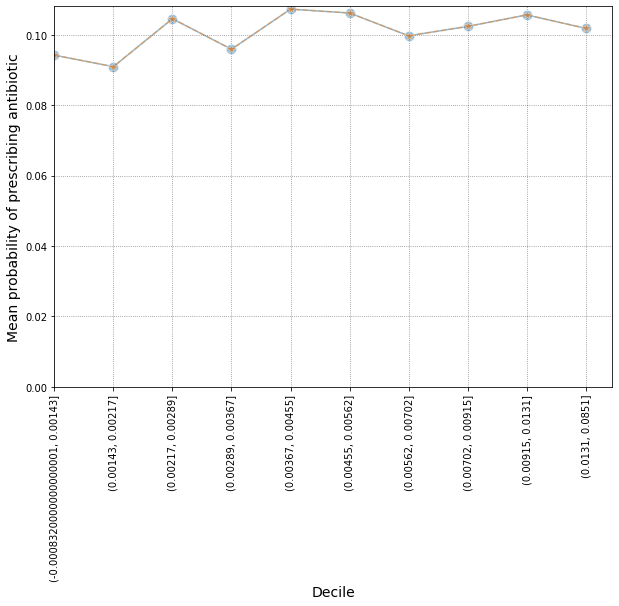


AUROC of LR for deciles with development and validation data: 0.51357 and 0.51197
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00143, 0.00217] -0.089749       -0.352585        0.173087   
1  bins_(0.00217, 0.00289]  0.085241       -0.157417        0.327898   
2  bins_(0.00289, 0.00367] -0.019233       -0.258892        0.220426   
3  bins_(0.00367, 0.00455]  0.048024       -0.204433        0.300481   
4  bins_(0.00455, 0.00562]  0.039763       -0.198497        0.278022   
5  bins_(0.00562, 0.00702]  0.071886       -0.147315        0.291087   
6  bins_(0.00702, 0.00915]  0.023458       -0.210165        0.257081   
7   bins_(0.00915, 0.0131]  0.088561       -0.150823        0.327944   
8    bins_(0.0131, 0.0851]  0.013156       -0.251255        0.277568   

         or  or_lower_95%  or_upper_95%  
0  0.914160      0.702869      1.188969  
1  1.088979      0.854348      1.388047  
2  0.980951      0.771906      1.246608  
3  1.049196    

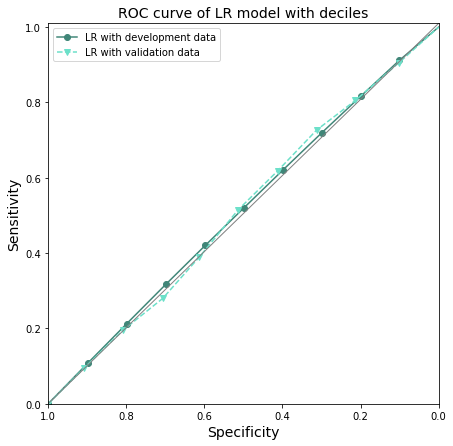

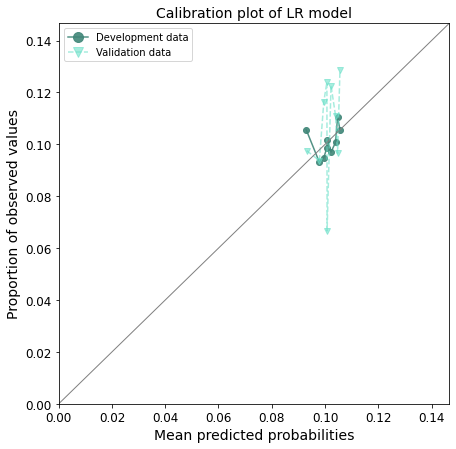


AUROC of LR for risk factors with development and validation data: 0.54258 and 0.50776
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34  0.214123        0.005640        0.422606   
1                 age_cat_35_44  0.100459       -0.129276        0.330193   
2                 age_cat_45_54  0.166976       -0.045933        0.379885   
3                 age_cat_55_64  0.083675       -0.136503        0.303853   
4                 age_cat_65_74  0.101639       -0.109260        0.312537   
5               age_cat_75_more  0.155487       -0.087361        0.398335   
6                      sex_male -0.083799       -0.193747        0.026149   
7                  CCI_cat_high  0.026771       -0.186436        0.239977   
8                   CCI_cat_low  0.075328       -0.100894        0.251551   
9                CCI_cat_medium  0.001344       -0.183647        0.186336   
10            CCI_cat_very_high  0.102841       -0.0

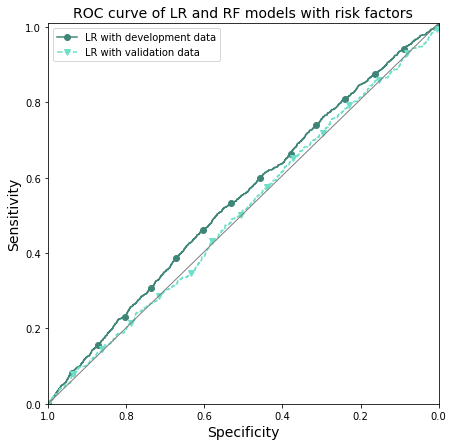

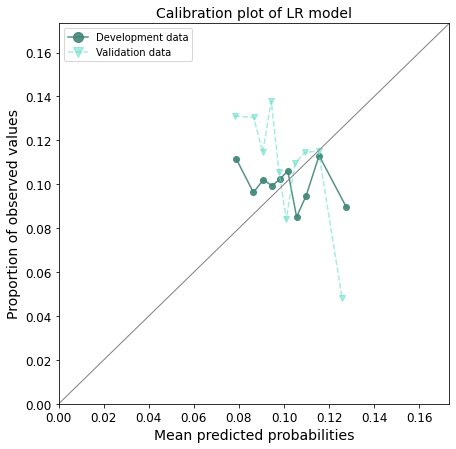

In [42]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_uti_no_abs_prevl, prob_pred_uti_no_abs_prevl_bin = cox_build('uti', 'prevl', data_uti_prevl, data_uti_no_abs_prevl)
except:
    print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_deciles('uti', 'prevl_deciles', prob_pred_uti_no_abs_prevl)
#calibration plots of rf and lr with deciles
calibration_rf_lr('uti', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('uti', 'prevl', prob_pred_enc_lr_rf_prevl)

# try:
#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_riskfactors('uti', 'prevl_riskfactors', prob_pred_uti_no_abs_prevl)
#calibration plots of rf and lr with risk factors
calibration_rf_lr('uti', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
# except:
#     print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

In [ ]:
#####age ab analysis
prob_pred_age = prob_pred_uti_no_abs_prevl.groupby('age_cat')[['ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
prob_pred_age

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28617 total observations, 28421 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 28617
number of events observed = 196
   partial log-likelihood = -1995.00
         time fit was run = 2023-08-07 22:10:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.91       0.22            -0.52             0.33                 0.60                 1.40
CCI_cat[T.medium]                0.03       1.03       0.24            -0.43             0.49                 0.65                 1.64
CCI_cat[T.high]                  0.06       1.07       0.28            -0.48             0.61                 0.62                 1.83
CCI_cat[T.very_high]             0.16       1.18       0.24            -0.31             0.63                 0.74                 1.89
age_cat[T.25_34]                -0.07       0.93       0.27            -0.59             0.45                 0.56                 1.57
age_cat[T.35_44]                -0.21       0.81       0.28            -0.75             0.34                 0.47                 1.40
age_cat[T.45_54]                 0.10       1.10       0.26            -0.40             0.60                 0.67                 1.83
age_cat[T.55_64]                 0.04       1.04       0.26            -0.47             0.55                 0.62                 1.73
age_cat[T.65_74]                -0.02       0.98       0.26            -0.54             0.49                 0.58                 1.63
age_cat[T.75_more]              -0.21       0.81       0.28            -0.75             0.33                 0.47                 1.39
antibacterial_brit              -0.10       0.91       0.05            -0.20             0.01                 0.82                 1.01
bmi_cat[T.obese]                 0.21       1.24       0.28            -0.34             0.77                 0.71                 2.17
bmi_cat[T.overweight]            0.12       1.12       0.35            -0.57             0.80                 0.57                 2.23
bmi_cat[T.underweight]           0.15       1.16       0.49            -0.80             1.11                 0.45                 3.03
bmi_cat[T.unknown]               0.23       1.25       0.30            -0.37             0.82                 0.69                 2.26
ethnicity[T.other]              -0.54       0.58       0.35            -1.22             0.14                 0.29                 1.15
ethnicity[T.unknown]            -0.69       0.50       0.26            -1.21            -0.17                 0.30                 0.84
ethnicity[T.white]              -0.43       0.65       0.23            -0.88             0.01                 0.42                 1.01
flu_vaccine[T.yes]               0.06       1.06       0.23            -0.40             0.51                 0.67                 1.67
imd[T.medium]                   -0.24       0.79       0.23            -0.68             0.21                 0.50                 1.24
imd[T.unaffluent]               -0.12       0.89       0.22            -0.55             0.31                 0.58                 1.37
imd[T.unknown]                   0.14       1.15       0.32            -0.48             0.76                 0.62                 2.13
imd[T.very_affluent]            -0.25       0.78       0.23            -0.70             0.20                 0.50                 1.22
imd[T.very_unaffluent]          -0.32       0.73       0.23            -0.78             0.13                 0.46                 1.14
region[T.east_midlands]          0.06       1.06       0.31           

13045


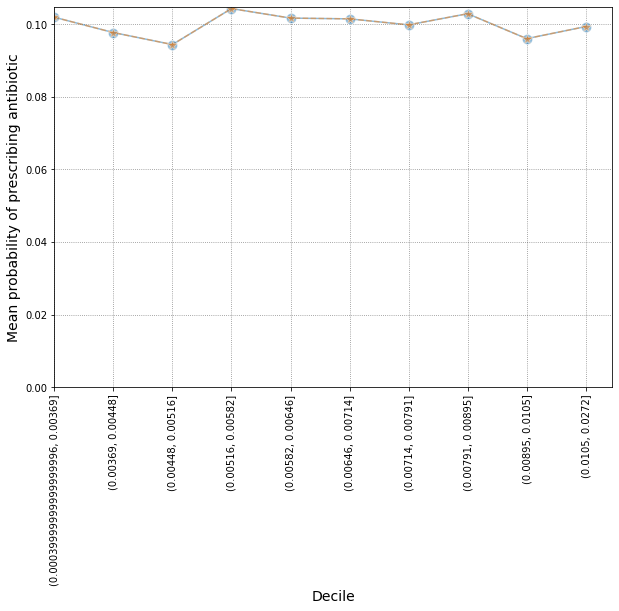


AUROC of LR for deciles with development and validation data: 0.50998 and 0.50179
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00369, 0.00448] -0.025447       -0.193969        0.143075   
1  bins_(0.00448, 0.00516] -0.091585       -0.264444        0.081273   
2  bins_(0.00516, 0.00582]  0.065393       -0.094214        0.225000   
3  bins_(0.00582, 0.00646]  0.035898       -0.126122        0.197918   
4  bins_(0.00646, 0.00714] -0.007774       -0.184486        0.168938   
5  bins_(0.00714, 0.00791] -0.001966       -0.150662        0.146731   
6  bins_(0.00791, 0.00895]  0.011861       -0.157615        0.181337   
7   bins_(0.00895, 0.0105] -0.020451       -0.187589        0.146687   
8    bins_(0.0105, 0.0272]  0.027969       -0.143621        0.199559   

         or  or_lower_95%  or_upper_95%  
0  0.974874      0.823684      1.153817  
1  0.912483      0.767633      1.084667  
2  1.067579      0.910088      1.252323  
3  1.036550    

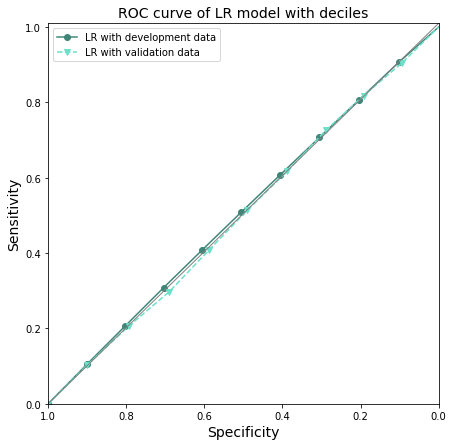

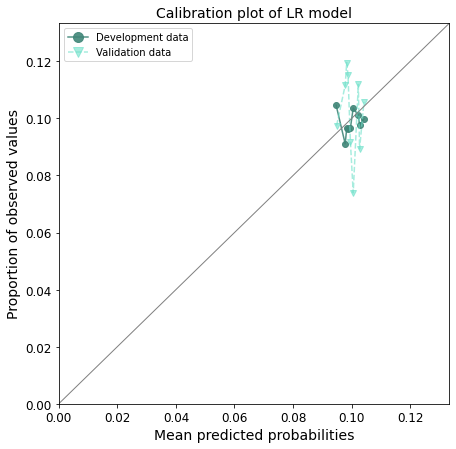

In [43]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_uti_no_abs_incdt_prepandemic, prob_pred_uti_no_abs_incdt_prepandemic_bin = cox_build('uti', 'incdt_prepandemic', data_uti_incdt_prepandemic, data_uti_no_abs_incdt_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('uti', 'incdt_prepandemic_deciles', prob_pred_uti_no_abs_incdt_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('uti', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic)#, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 26079 total observations, 25920 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 26079
number of events observed = 159
   partial log-likelihood = -1599.47
         time fit was run = 2023-08-07 22:10:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.23            -0.40             0.51                 0.67                 1.67
CCI_cat[T.medium]               -0.03       0.97       0.26            -0.55             0.48                 0.58                 1.61
CCI_cat[T.high]                  0.08       1.09       0.30            -0.50             0.67                 0.60                 1.95
CCI_cat[T.very_high]            -0.19       0.83       0.29            -0.75             0.38                 0.47                 1.46
age_cat[T.25_34]                -0.10       0.90       0.30            -0.70             0.49                 0.50                 1.63
age_cat[T.35_44]                -0.28       0.76       0.31            -0.90             0.34                 0.41                 1.40
age_cat[T.45_54]                 0.07       1.07       0.29            -0.50             0.63                 0.61                 1.89
age_cat[T.55_64]                 0.06       1.07       0.29            -0.50             0.63                 0.61                 1.88
age_cat[T.65_74]                -0.24       0.79       0.31            -0.85             0.38                 0.43                 1.46
age_cat[T.75_more]               0.25       1.28       0.28            -0.30             0.79                 0.74                 2.21
antibacterial_brit               0.00       1.00       0.06            -0.11             0.11                 0.90                 1.12
bmi_cat[T.obese]                 0.28       1.32       0.32            -0.35             0.91                 0.70                 2.47
bmi_cat[T.overweight]           -0.37       0.69       0.44            -1.22             0.49                 0.29                 1.63
bmi_cat[T.underweight]           0.53       1.69       0.48            -0.42             1.48                 0.66                 4.37
bmi_cat[T.unknown]               0.29       1.33       0.34            -0.37             0.95                 0.69                 2.58
ethnicity[T.other]              -0.07       0.93       0.39            -0.83             0.69                 0.44                 1.99
ethnicity[T.unknown]            -0.08       0.92       0.31            -0.69             0.52                 0.50                 1.68
ethnicity[T.white]              -0.23       0.80       0.29            -0.79             0.34                 0.45                 1.40
flu_vaccine[T.yes]               0.17       1.18       0.25            -0.32             0.66                 0.72                 1.93
imd[T.medium]                    0.15       1.17       0.25            -0.34             0.65                 0.71                 1.92
imd[T.unaffluent]               -0.09       0.91       0.27            -0.62             0.44                 0.54                 1.55
imd[T.unknown]                   0.41       1.51       0.35            -0.29             1.10                 0.75                 3.02
imd[T.very_affluent]             0.10       1.11       0.25            -0.40             0.60                 0.67                 1.83
imd[T.very_unaffluent]          -0.12       0.89       0.27            -0.65             0.41                 0.52                 1.51
region[T.east_midlands]         -0.39       0.68       0.43           

13038


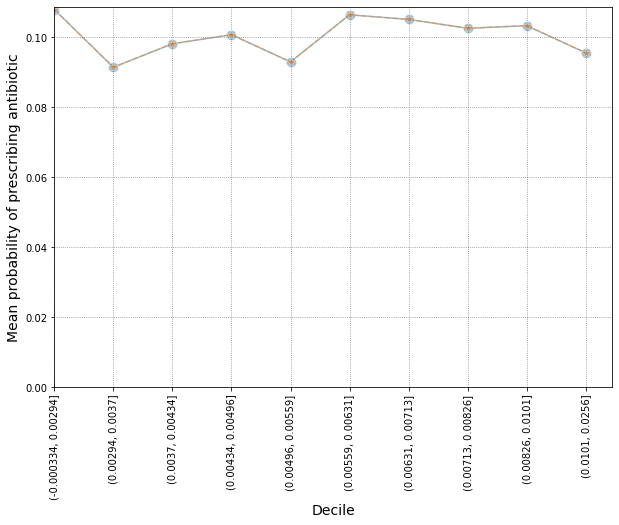


AUROC of LR for deciles with development and validation data: 0.51543 and 0.51400
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0   bins_(0.00294, 0.0037] -0.140290       -0.281075        0.000495   
1   bins_(0.0037, 0.00434] -0.064944       -0.210449        0.080561   
2  bins_(0.00434, 0.00496] -0.042307       -0.215772        0.131157   
3  bins_(0.00496, 0.00559] -0.161873       -0.333883        0.010137   
4  bins_(0.00559, 0.00631] -0.044387       -0.195541        0.106767   
5  bins_(0.00631, 0.00713]  0.000018       -0.154519        0.154554   
6  bins_(0.00713, 0.00826]  0.015018       -0.149511        0.179546   
7   bins_(0.00826, 0.0101] -0.058292       -0.226952        0.110369   
8    bins_(0.0101, 0.0256] -0.089849       -0.240624        0.060926   

         or  or_lower_95%  or_upper_95%  
0  0.869106      0.754972      1.000495  
1  0.937120      0.810220      1.083894  
2  0.958575      0.805919      1.140147  
3  0.850549    

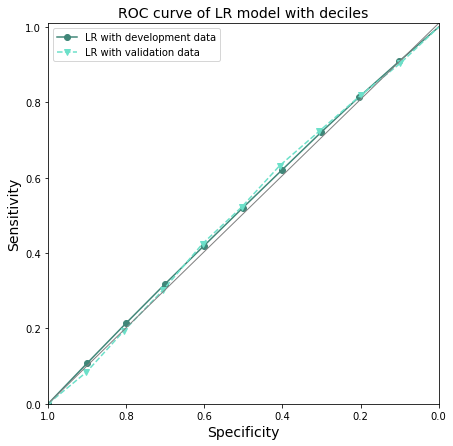

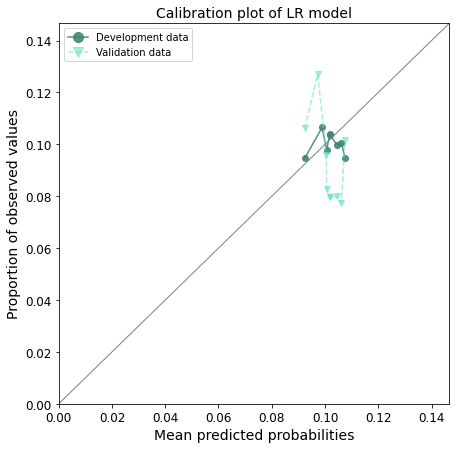

In [44]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_uti_no_abs_incdt_during_pandemic, prob_pred_uti_no_abs_incdt_during_pandemic_bin = cox_build('uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic, data_uti_no_abs_incdt_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('uti', 'incdt_during_pandemic_deciles', prob_pred_uti_no_abs_incdt_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('uti', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic)#, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 47775 total observations, 47458 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 47775
number of events observed = 317
   partial log-likelihood = -3386.27
         time fit was run = 2023-08-07 22:10:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.08       0.17            -0.26             0.42                 0.77                 1.52
CCI_cat[T.medium]               -0.04       0.96       0.20            -0.43             0.34                 0.65                 1.41
CCI_cat[T.high]                  0.42       1.53       0.21             0.01             0.83                 1.01                 2.29
CCI_cat[T.very_high]             0.26       1.30       0.19            -0.12             0.64                 0.89                 1.89
age_cat[T.25_34]                -0.10       0.90       0.21            -0.51             0.31                 0.60                 1.36
age_cat[T.35_44]                -0.16       0.85       0.21            -0.57             0.26                 0.56                 1.30
age_cat[T.45_54]                -0.15       0.86       0.21            -0.56             0.27                 0.57                 1.31
age_cat[T.55_64]                -0.17       0.84       0.21            -0.59             0.25                 0.56                 1.28
age_cat[T.65_74]                -0.00       1.00       0.21            -0.41             0.40                 0.67                 1.49
age_cat[T.75_more]               0.11       1.12       0.20            -0.28             0.51                 0.76                 1.66
antibacterial_brit              -0.11       0.90       0.04            -0.19            -0.03                 0.83                 0.97
bmi_cat[T.obese]                -0.03       0.97       0.21            -0.44             0.38                 0.64                 1.46
bmi_cat[T.overweight]            0.16       1.18       0.25            -0.32             0.64                 0.73                 1.91
bmi_cat[T.underweight]          -0.14       0.87       0.39            -0.89             0.62                 0.41                 1.85
bmi_cat[T.unknown]              -0.12       0.89       0.22            -0.56             0.32                 0.57                 1.38
ethnicity[T.other]               0.05       1.05       0.28            -0.50             0.60                 0.61                 1.82
ethnicity[T.unknown]            -0.18       0.84       0.23            -0.63             0.28                 0.53                 1.32
ethnicity[T.white]              -0.03       0.97       0.21            -0.44             0.39                 0.64                 1.48
flu_vaccine[T.yes]              -0.30       0.74       0.21            -0.72             0.12                 0.49                 1.12
imd[T.medium]                    0.18       1.19       0.18            -0.17             0.53                 0.84                 1.69
imd[T.unaffluent]               -0.07       0.94       0.19            -0.43             0.30                 0.65                 1.35
imd[T.unknown]                   0.24       1.27       0.26            -0.28             0.76                 0.76                 2.13
imd[T.very_affluent]             0.01       1.01       0.18            -0.35             0.37                 0.71                 1.45
imd[T.very_unaffluent]          -0.07       0.93       0.19            -0.44             0.30                 0.65                 1.35
region[T.east_midlands]         -0.29       0.75       0.25           

13060


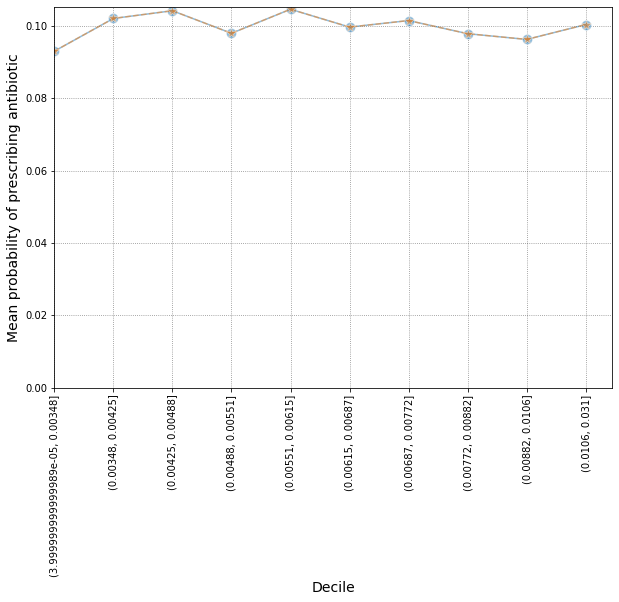


AUROC of LR for deciles with development and validation data: 0.51343 and 0.50022
LR summary:
                                covariate      coef  coef_lower_95%  \
0                bins_(0.00425, 0.00488]  0.088338       -0.026419   
1                bins_(0.00488, 0.00551] -0.027548       -0.144285   
2                bins_(0.00551, 0.00615]  0.074302       -0.031324   
3                bins_(0.00615, 0.00687]  0.018163       -0.099534   
4                bins_(0.00687, 0.00772]  0.068521       -0.056422   
5                bins_(0.00772, 0.00882] -0.009009       -0.128914   
6                 bins_(0.00882, 0.0106] -0.058275       -0.168100   
7                   bins_(0.0106, 0.031]  0.012118       -0.093213   
8  bins_(3.999999999999989e-05, 0.00348] -0.051588       -0.168811   

   coef_upper_95%        or  or_lower_95%  or_upper_95%  
0        0.203094  1.092357      0.973927      1.225188  
1        0.089189  0.972828      0.865641      1.093287  
2        0.179928  1.077132  

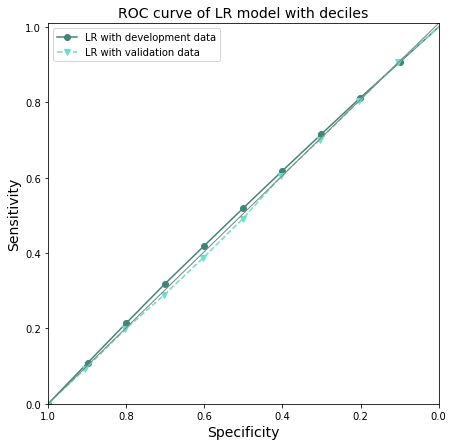

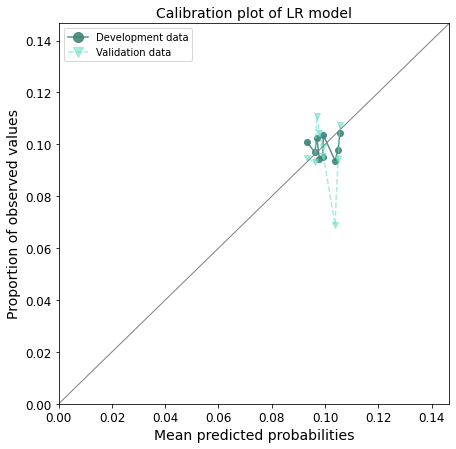

In [45]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_uti_no_abs_incdt_post_2nd_lockdown, prob_pred_uti_no_abs_incdt_post_2nd_lockdown_bin = cox_build('uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown, data_uti_no_abs_incdt_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('uti', 'incdt_post_2nd_lockdown_deciles', prob_pred_uti_no_abs_incdt_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('uti', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown)#, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3241 total observations, 3223 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 3241
number of events observed = 18
   partial log-likelihood = -120.40
         time fit was run = 2023-08-07 22:11:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.43       4.17       1.07            -0.66             3.52                 0.52                33.69
CCI_cat[T.medium]                0.37       1.44       1.24            -2.06             2.79                 0.13                16.32
CCI_cat[T.high]                  1.30       3.66       1.17            -0.99             3.59                 0.37                36.22
CCI_cat[T.very_high]             0.85       2.34       1.17            -1.44             3.15                 0.24                23.26
age_cat[T.25_34]                18.57   1.16e+08    5108.82         -9994.54         10031.68                 0.00                  inf
age_cat[T.35_44]                18.62   1.22e+08    5108.82         -9994.49         10031.73                 0.00                  inf
age_cat[T.45_54]                18.75   1.39e+08    5108.82         -9994.36         10031.86                 0.00                  inf
age_cat[T.55_64]                17.80   5.35e+07    5108.82         -9995.32         10030.91                 0.00                  inf
age_cat[T.65_74]                17.28   3.19e+07    5108.82         -9995.83         10030.39                 0.00                  inf
age_cat[T.75_more]              18.39   9.71e+07    5108.82         -9994.72         10031.50                 0.00                  inf
antibacterial_brit               0.15       1.16       0.17            -0.17             0.47                 0.84                 1.61
bmi_cat[T.obese]                -0.89       0.41       0.69            -2.25             0.47                 0.11                 1.59
bmi_cat[T.overweight]           -1.59       0.20       1.18            -3.91             0.73                 0.02                 2.08
bmi_cat[T.underweight]           0.09       1.09       1.20            -2.27             2.44                 0.10                11.45
bmi_cat[T.unknown]              -1.08       0.34       0.79            -2.64             0.47                 0.07                 1.60
ethnicity[T.other]              -0.33       0.72       1.04            -2.37             1.71                 0.09                 5.50
ethnicity[T.unknown]            -0.72       0.49       0.90            -2.48             1.04                 0.08                 2.83
ethnicity[T.white]              -0.65       0.52       0.80            -2.22             0.93                 0.11                 2.53
flu_vaccine[T.yes]              -0.73       0.48       1.06            -2.80             1.34                 0.06                 3.83
imd[T.medium]                  -17.23       0.00    5208.30        -10225.30         10190.85                 0.00                  inf
imd[T.unaffluent]              -17.13       0.00    5352.33        -10507.50         10473.24                 0.00                  inf
imd[T.unknown]                   2.43      11.41       1.18             0.13             4.74                 1.14               114.18
imd[T.very_affluent]             1.79       5.99       1.08            -0.32             3.90                 0.73                49.25
imd[T.very_unaffluent]           1.91       6.73       1.07            -0.20             4.01                 0.82                55.36
region[T.east_midlands]         -0.98       0.37       1.17            -3.2

13150


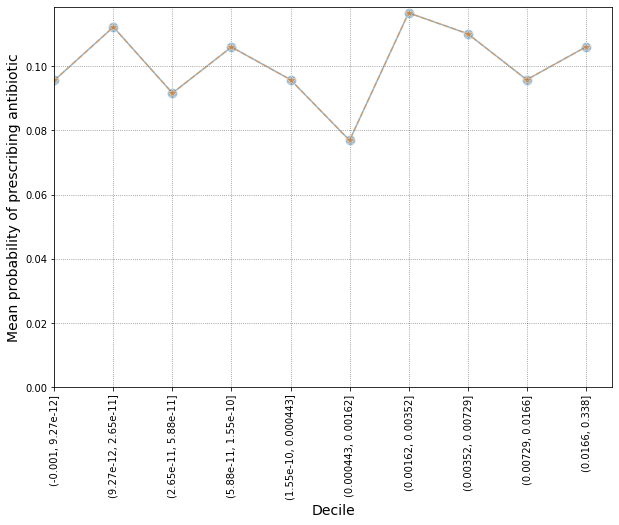


AUROC of LR for deciles with development and validation data: 0.53212 and 0.48859
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0   bins_(0.000443, 0.00162] -0.102524       -0.510005        0.304957   
1    bins_(0.00162, 0.00352]  0.146606       -0.251124        0.544336   
2    bins_(0.00352, 0.00729]  0.135378       -0.252462        0.523218   
3     bins_(0.00729, 0.0166]  0.192704       -0.229579        0.614987   
4       bins_(0.0166, 0.338] -0.094525       -0.531606        0.342557   
5  bins_(1.55e-10, 0.000443]  0.034246       -0.330070        0.398561   
6  bins_(2.65e-11, 5.88e-11]  0.058289       -0.383497        0.500076   
7  bins_(5.88e-11, 1.55e-10]  0.179227       -0.251855        0.610309   
8  bins_(9.27e-12, 2.65e-11]  0.288469       -0.121921        0.698858   

         or  or_lower_95%  or_upper_95%  
0  0.902556      0.600493      1.356566  
1  1.157898      0.777926      1.723464  
2  1.144969      0.776886      1.6874

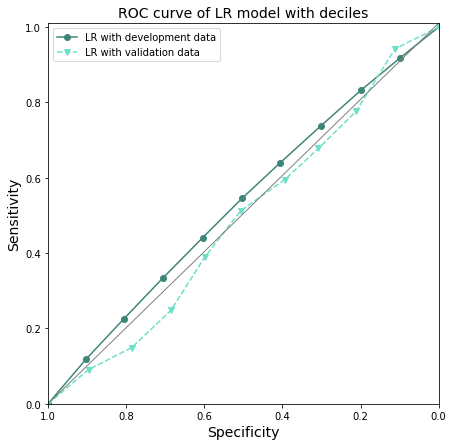

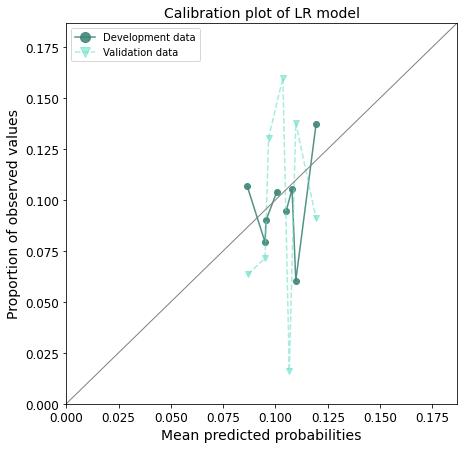

In [46]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_uti_no_abs_prevl_prepandemic, prob_pred_uti_no_abs_prevl_prepandemic_bin = cox_build('uti', 'prevl_prepandemic', data_uti_prevl_prepandemic, data_uti_no_abs_prevl_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('uti', 'prevl_prepandemic_deciles', prob_pred_uti_no_abs_prevl_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('uti', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic)#, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 2866 total observations, 2849 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 2866
number of events observed = 17
   partial log-likelihood = -103.05
         time fit was run = 2023-08-07 22:11:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.33       1.40       0.82            -1.28             1.95                 0.28                 7.02
CCI_cat[T.medium]               -0.44       0.64       1.02            -2.44             1.55                 0.09                 4.73
CCI_cat[T.high]                -18.93       0.00   10098.35        -19811.32         19773.46                 0.00                  inf
CCI_cat[T.very_high]             1.37       3.95       0.85            -0.29             3.04                 0.75                20.86
age_cat[T.25_34]                -0.83       0.44       0.86            -2.51             0.85                 0.08                 2.34
age_cat[T.35_44]               -19.62       0.00    8137.44        -15968.70         15929.47                 0.00                  inf
age_cat[T.45_54]                -1.54       0.22       1.12            -3.73             0.66                 0.02                 1.93
age_cat[T.55_64]                -0.40       0.67       0.77            -1.91             1.11                 0.15                 3.05
age_cat[T.65_74]                -0.21       0.81       0.72            -1.62             1.19                 0.20                 3.28
age_cat[T.75_more]              -0.77       0.46       0.86            -2.46             0.93                 0.09                 2.52
antibacterial_brit              -0.23       0.80       0.20            -0.62             0.17                 0.54                 1.19
bmi_cat[T.obese]                18.68   1.30e+08   11431.72        -22387.07         22424.43                 0.00                  inf
bmi_cat[T.overweight]           18.42   9.96e+07   11431.72        -22387.33         22424.17                 0.00                  inf
bmi_cat[T.underweight]          -0.24       0.79   24963.34        -48927.49         48927.02                 0.00                  inf
bmi_cat[T.unknown]              19.81   4.01e+08   11431.72        -22385.94         22425.56                 0.00                  inf
ethnicity[T.other]              -0.94       0.39       1.20            -3.29             1.41                 0.04                 4.08
ethnicity[T.unknown]            -0.63       0.53       0.80            -2.20             0.93                 0.11                 2.54
ethnicity[T.white]              -0.97       0.38       0.72            -2.38             0.44                 0.09                 1.55
flu_vaccine[T.yes]              -0.21       0.81       1.06            -2.28             1.86                 0.10                 6.43
imd[T.medium]                   -1.21       0.30       0.73            -2.63             0.21                 0.07                 1.24
imd[T.unaffluent]               -1.02       0.36       0.72            -2.42             0.39                 0.09                 1.48
imd[T.unknown]                 -20.02       0.00   17816.52        -34939.77         34899.72                 0.00                  inf
imd[T.very_affluent]           -20.09       0.00    7873.08        -15451.04         15410.86                 0.00                  inf
imd[T.very_unaffluent]          -1.11       0.33       0.73            -2.55             0.32                 0.08                 1.38
region[T.east_midlands]        -18.31       0.00   10804.13        -21194.0

13201


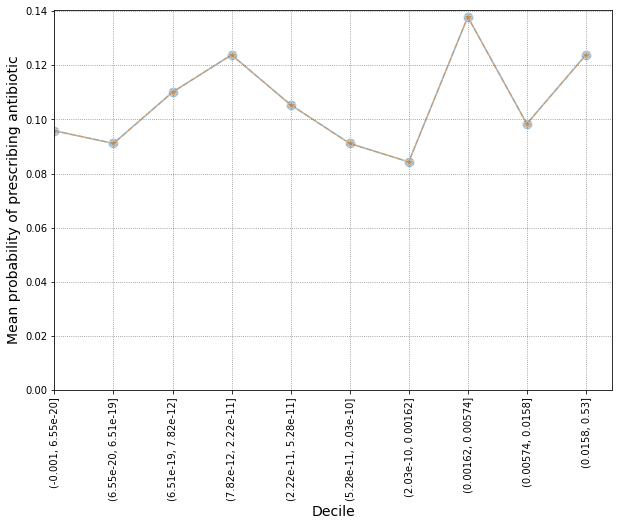


AUROC of LR for deciles with development and validation data: 0.54750 and 0.52007
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0    bins_(0.00162, 0.00574]  0.125767       -0.358894        0.610427   
1     bins_(0.00574, 0.0158] -0.130987       -0.632899        0.370924   
2        bins_(0.0158, 0.53]  0.138285       -0.291718        0.568288   
3   bins_(2.03e-10, 0.00162] -0.412847       -0.872662        0.046968   
4  bins_(2.22e-11, 5.28e-11]  0.029445       -0.398689        0.457580   
5  bins_(5.28e-11, 2.03e-10] -0.267997       -0.775104        0.239109   
6  bins_(6.51e-19, 7.82e-12]  0.014158       -0.424351        0.452668   
7  bins_(6.55e-20, 6.51e-19] -0.282551       -0.795767        0.230665   
8  bins_(7.82e-12, 2.22e-11] -0.069753       -0.525387        0.385880   

         or  or_lower_95%  or_upper_95%  
0  1.134017      0.698448      1.841218  
1  0.877229      0.531050      1.449073  
2  1.148303      0.746979      1.7652

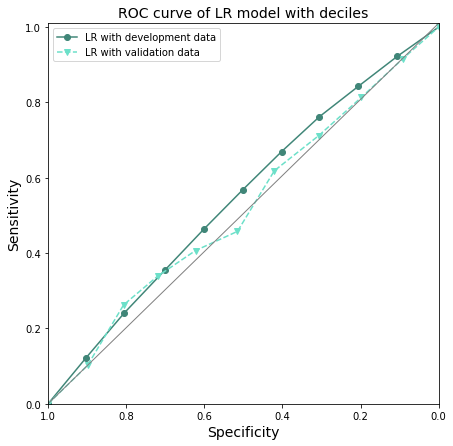

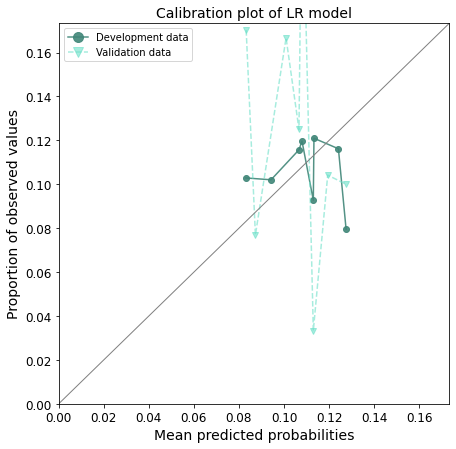

In [47]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_uti_no_abs_prevl_during_pandemic, prob_pred_uti_no_abs_prevl_during_pandemic_bin = cox_build('uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic, data_uti_no_abs_prevl_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('uti', 'prevl_during_pandemic_deciles', prob_pred_uti_no_abs_prevl_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('uti', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic)#, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 5268 total observations, 5235 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 5268
number of events observed = 33
   partial log-likelihood = -267.60
         time fit was run = 2023-08-07 22:11:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.72       2.06       0.64            -0.53             1.98                 0.59                 7.21
CCI_cat[T.medium]                0.20       1.22       0.73            -1.24             1.64                 0.29                 5.15
CCI_cat[T.high]                  0.27       1.32       0.82            -1.33             1.88                 0.26                 6.56
CCI_cat[T.very_high]             0.92       2.51       0.68            -0.41             2.26                 0.66                 9.56
age_cat[T.25_34]                -0.44       0.64       0.73            -1.88             0.99                 0.15                 2.70
age_cat[T.35_44]                 0.39       1.47       0.59            -0.77             1.54                 0.46                 4.68
age_cat[T.45_54]                 0.07       1.07       0.63            -1.17             1.31                 0.31                 3.71
age_cat[T.55_64]                -0.42       0.65       0.73            -1.86             1.01                 0.16                 2.76
age_cat[T.65_74]                -0.14       0.87       0.68            -1.46             1.19                 0.23                 3.28
age_cat[T.75_more]               0.27       1.31       0.61            -0.92             1.47                 0.40                 4.33
antibacterial_brit              -0.05       0.95       0.13            -0.30             0.20                 0.74                 1.22
bmi_cat[T.obese]                -0.71       0.49       0.52            -1.74             0.31                 0.18                 1.36
bmi_cat[T.overweight]           -0.57       0.57       0.68            -1.90             0.76                 0.15                 2.13
bmi_cat[T.underweight]          -0.58       0.56       1.10            -2.73             1.58                 0.07                 4.84
bmi_cat[T.unknown]              -0.70       0.49       0.58            -1.83             0.42                 0.16                 1.53
ethnicity[T.other]               1.87       6.47       1.07            -0.23             3.97                 0.79                52.97
ethnicity[T.unknown]             1.09       2.98       1.06            -0.98             3.16                 0.38                23.63
ethnicity[T.white]               0.74       2.10       1.03            -1.28             2.77                 0.28                15.93
flu_vaccine[T.yes]              -0.25       0.78       0.61            -1.44             0.95                 0.24                 2.59
imd[T.medium]                   -0.27       0.76       0.54            -1.33             0.79                 0.26                 2.21
imd[T.unaffluent]               -0.69       0.50       0.61            -1.90             0.51                 0.15                 1.67
imd[T.unknown]                   0.63       1.88       0.62            -0.58             1.84                 0.56                 6.31
imd[T.very_affluent]            -1.00       0.37       0.68            -2.33             0.33                 0.10                 1.40
imd[T.very_unaffluent]           0.02       1.02       0.50            -0.97             1.01                 0.38                 2.73
region[T.east_midlands]          0.01       1.01       1.00            -1.9

13036


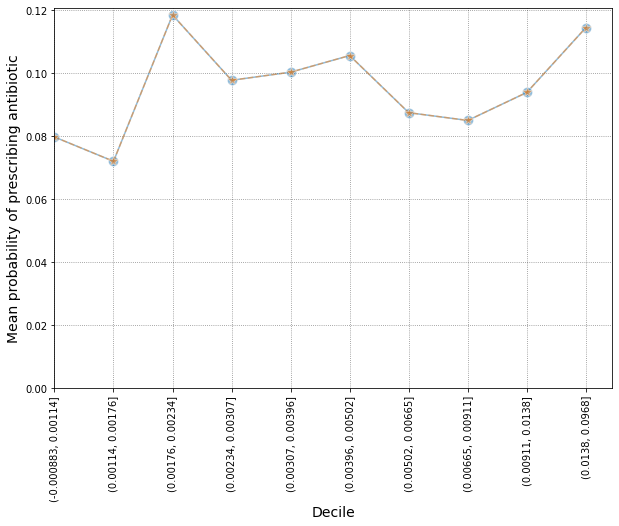


AUROC of LR for deciles with development and validation data: 0.55806 and 0.50350
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00114, 0.00176] -0.261503       -0.648295        0.125289   
1  bins_(0.00176, 0.00234]  0.369803        0.019887        0.719718   
2  bins_(0.00234, 0.00307]  0.169050       -0.158637        0.496737   
3  bins_(0.00307, 0.00396]  0.163588       -0.195453        0.522629   
4  bins_(0.00396, 0.00502]  0.396229        0.036634        0.755823   
5  bins_(0.00502, 0.00665]  0.076509       -0.286904        0.439921   
6  bins_(0.00665, 0.00911]  0.005993       -0.417020        0.429005   
7   bins_(0.00911, 0.0138]  0.154012       -0.200353        0.508376   
8    bins_(0.0138, 0.0968]  0.489290        0.082499        0.896081   

         or  or_lower_95%  or_upper_95%  
0  0.769894      0.522937      1.133476  
1  1.447449      1.020086      2.053855  
2  1.184180      0.853306      1.643351  
3  1.177729    

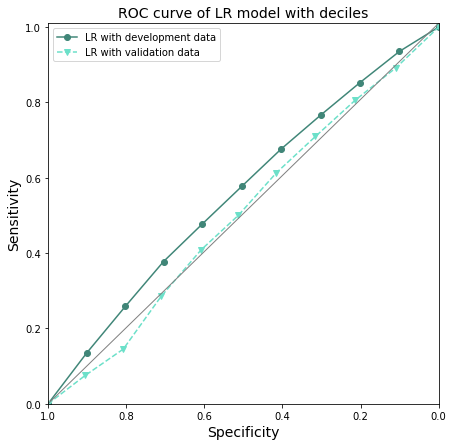

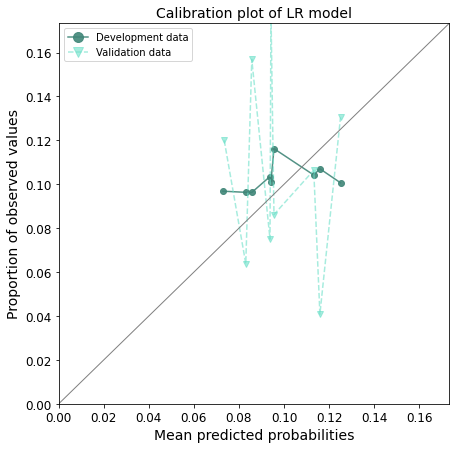

: 

In [48]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_uti_no_abs_prevl_post_2nd_lockdown, prob_pred_uti_no_abs_prevl_post_2nd_lockdown_bin = cox_build('uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown, data_uti_no_abs_prevl_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('uti', 'prevl_post_2nd_lockdown_deciles', prob_pred_uti_no_abs_prevl_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('uti', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown)#, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")